<a href="https://colab.research.google.com/github/aniketDL/lung_xray_detection_fastai/blob/master/xray_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fastai import *
from fastai.vision import *
from fastai.imports import *
import os

In [0]:
import json


**Below code cells from [5] to [11] are steps to download data from kaggle onto google colab**




In [0]:
from google.colab import files
files.upload()
#uploaded my kaggle.json API key

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

In [0]:
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json

In [0]:
!pip install -q kaggle
!pip install -q kaggle-cli

In [0]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [12]:
!ls

chest-xray-pneumonia.zip  kaggle.json  sample_data


In [14]:
!unzip './chest-xray-pneumonia.zip'

Archive:  ./chest-xray-pneumonia.zip
  inflating: chest_xray.zip          


In [15]:
!ls

chest-xray-pneumonia.zip  chest_xray.zip  kaggle.json  sample_data


In [0]:
#!unzip './chest_xray.zip'

In [21]:
!ls

chest_xray		  chest_xray.zip  __MACOSX
chest-xray-pneumonia.zip  kaggle.json	  sample_data


In [22]:
cd './chest_xray'

/content/chest_xray


In [110]:
!ls

export.pkl  models  test  train  val


In [0]:
path = Path('/content/chest_xray')

In [31]:
path.ls()

[PosixPath('/content/chest_xray/test'),
 PosixPath('/content/chest_xray/val'),
 PosixPath('/content/chest_xray/.DS_Store'),
 PosixPath('/content/chest_xray/train')]

In [0]:
bs = 64 # Batch size of 64 to speed up training of model

In [0]:
# random seed used to duplicate the same results on multiple tries
# ImageDataBunch will create training and validation datasets. Size of each image is 224 x 224. batch size is 64. normalization used as per imagenet dataset.
np.random.seed(2)
data = ImageDataBunch.from_folder(path, valid='val',valid_pct=0.1,size=224, bs=bs,
                                  ds_tfms=get_transforms()).normalize(imagenet_stats)



In [51]:
data.classes

['NORMAL', 'PNEUMONIA']

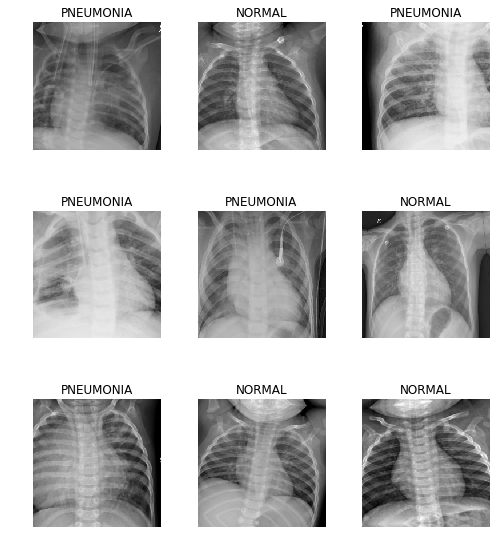

In [53]:
data.show_batch(rows=3, figsize=(7,8)) #9 examples from the dataset

In [54]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds) #types of classes, number of classes, number of training data points, number of validation data points

(['NORMAL', 'PNEUMONIA'], 2, 5271, 585)

In [55]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy) 
# trained using a resnet50 convnet. Currently the best image classification neural network. resnet50 uses pre-trained weights based on imagenet dataset.
# the last couple of layers of the neural net are re-trained based on our dataset. This process of using pre-trained neural nets is called Transfer Learning.
# Transfer Learning is extremely beneficial as a lot of low-level features do not need to be trained again, thus helping improve speed and accuracy.

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:02<00:00, 48718867.84it/s]


In [56]:
learn.fit_one_cycle(4) #

epoch,train_loss,valid_loss,accuracy,time
0,0.318392,0.259629,0.912821,04:35
1,0.209018,0.128689,0.948718,04:35
2,0.158462,0.117833,0.952137,04:35
3,0.137887,0.121471,0.952137,04:34


In [0]:
learn.save('stage-1') # this saves the above model as 'stage-1'

In [0]:
learn.unfreeze() # this 'unfreezes' the model, i.e, allows you to re-train all the layers of the model and not just the final layers. Therefore, we can update weights of all the layers
# The reason we 

In [59]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


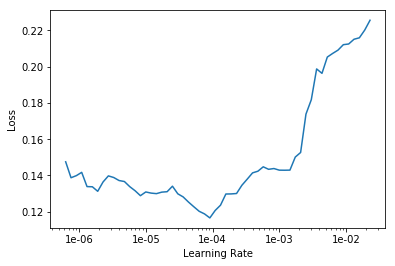

In [60]:
learn.recorder.plot()

In [0]:
# from the above plot:
# - the default learning rate is 0.003 ,i.e, 3e-3, where the loss is quite high
# - you can see that the model performed best between 3e-5, 1e-4
# - lets try and re-learn the model with the learning rates within those bounds

In [61]:
learn.fit_one_cycle(5, max_lr=slice(3e-5, 1e-4)) 
# by adjusting the learning rate range, we were able to improve accuracy by close to 2% !

epoch,train_loss,valid_loss,accuracy,time
0,0.130504,0.144053,0.952137,04:42
1,0.126675,0.095751,0.972650,04:42
2,0.097533,0.082053,0.970940,04:43
3,0.071370,0.074311,0.976068,04:40
4,0.062908,0.083944,0.974359,04:40


In [0]:
learn.save('stage-2')

In [0]:
learn.load('stage-2');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

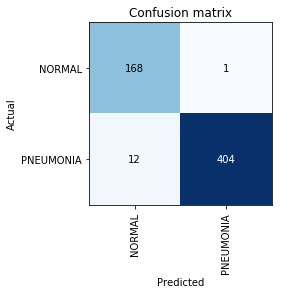

In [68]:
interp.plot_confusion_matrix() #below confusion matrix shows that we get 12 predictions wrong for Normal vs Pneumonia but 1 prediction wrong for Pneumonia vs Normal

In [0]:
learn.export() #This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model 

In [89]:
!pwd

/content/chest_xray/test/NORMAL


In [0]:
defaults.device = torch.device('cpu') #use 'cpu' instead 'gpu' for inference because we probably won't get TONS of traffic so no need to use distributed computing power

In [80]:
path

PosixPath('/content/chest_xray')

In [0]:
img = open_image(path/'test'/'PNEUMONIA'/'person1_virus_7.jpeg')

In [95]:
# we used an image from the test folder and successfully predicted PNEUMONIA !
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category PNEUMONIA

In [0]:
learn = load_learner(path)